In [1]:
import os
import datetime
import pandas as pd
import numpy as np
from lxml import etree
from tqdm import tqdm

In [4]:
# The base_path should be the results with labels generated in ../data_preparations/add_labels.py
base_path = r"C:\Users\Olive\python_projects\FinRL-Meta\FinGPT-ChatGLM-Fineturning_old\Chinese_News\scrape\content_with_labels"
columns = ["instruction","input","output"]
instruction = "What is the sentiment of this news? Answer:{very negative/negative/neutral/positive/very positive}"

file_list = os.listdir(base_path)
print(instruction)

What is the sentiment of this news? Answer:{very negative/negative/neutral/positive/very positive}


### Title/标题

In [3]:
dataset = pd.DataFrame(columns= columns)
for file_name in tqdm(file_list):
    df = pd.read_csv(os.path.join(base_path, file_name))
    df["input"] = df.apply(lambda x: f'今天的日期为：{x["publish_date"]}。\n新闻标题为：\"{x["post_title"]}\"。', axis = 1)
    df["instruction"] = instruction
    df['output'] = df["label"]
    tmp = df[columns+["date"]]
    dataset = pd.concat([dataset, tmp])

100%|██████████| 216/216 [00:33<00:00,  6.47it/s]


In [4]:
dataset

,instruction,input,output,date
0,What is the sentiment of this news?\nAnswer:{v...,"今天的日期为：2023-04-07。\n新闻标题为：""平安银行：融资净买入3199.17万元...",No data,2023-04-07
1,What is the sentiment of this news?\nAnswer:{v...,"今天的日期为：2023-04-07。\n新闻标题为：""平安银行今日大宗交易折价成交198万股...",No data,2023-04-06
2,What is the sentiment of this news?\nAnswer:{v...,"今天的日期为：2023-04-06。\n新闻标题为：""平安银行：融资净偿还1627.94万元...",No data,2023-04-06
3,What is the sentiment of this news?\nAnswer:{v...,"今天的日期为：2023-04-05。\n新闻标题为：""平安银行04月04日被深股通减持301...",No data,2023-04-05
4,What is the sentiment of this news?\nAnswer:{v...,"今天的日期为：2023-04-02。\n新闻标题为：""平安银行本周深股通持股市值增加1.09...",No data,2023-04-02
...,...,...,...,...
977,What is the sentiment of this news?\nAnswer:{v...,"今天的日期为：2021-04-22。\n新闻标题为：""德业股份一字涨停，年报业绩同比增加47...",very negative,2021-04-21
978,What is the sentiment of this news?\nAnswer:{v...,"今天的日期为：2021-04-21。\n新闻标题为：""德业股份今日正式登陆沪市主板 多元化发...",negative,2021-04-20
979,What is the sentiment of this news?\nAnswer:{v...,"今天的日期为：2021-04-21。\n新闻标题为：""N德业（605117）龙虎榜数据（04...",negative,2021-04-20
980,What is the sentiment of this news?\nAnswer:{v...,"今天的日期为：2021-04-21。\n新闻标题为：""德业股份封涨停板 三机构卖出64万元""。",negative,2021-04-20


In [10]:
dataset = dataset[dataset.output != "No data"]

In [11]:
dataset.date.sort_values().unique()

array(['2011-05-12', '2011-05-13', '2011-05-16', ..., '2023-03-29',
       '2023-03-30', '2023-03-31'], dtype=object)

<AxesSubplot:xlabel='date'>

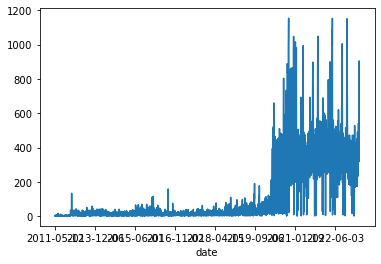

In [12]:
dataset.groupby("date").date.count().plot()

#####  Test from 2022-04-01 till 2023-03-31
#####  Train & valid from 2011-05-12 till 2022-03-31

In [22]:
dataset[dataset.date<"2022-04-01"].shape

(354608, 4)

In [14]:
dataset.shape

(492549, 4)

In [4]:
print(df["input"][0])

今天的日期为：2023-04-08。
新闻标题为："德业股份：融资净偿还759.19万元，融资余额4.73亿元（04-07）"。


In [ ]:
# Train & valid
train_valid = dataset[dataset.date < "2022-04-01"][columns]
train_valid.to_csv("content/dataset_title_train_and_valid.csv", index = False)

In [24]:
# Test
test = dataset[dataset.date >= "2022-04-01"][columns]
test.to_csv("content/dataset_title_test.csv", index = False)

In [ ]:
data_list = []
for item in train_valid.itertuples():
    tmp = {}
    tmp["instruction"] = item.instruction
    tmp["input"] = item.input
    tmp["output"] = item.output
    data_list.append(tmp)

In [ ]:
# To Json
import json
with open("content/dataset_title_train_and_valid.json", "w+", encoding='utf-8') as f:
    json.dump(data_list, f, ensure_ascii= False)

In [ ]:
# To Json
import json
with open("content/dataset_title_test.json", "w+", encoding='utf-8') as f:
    json.dump(data_list, f, ensure_ascii= False)

### Contetn/内容

In [26]:
def get_content(x):
    try:
        tree = etree.HTML(x)
        content = tree.xpath("//*[name(.)!='style']/text()")
        content = "".join(content)
        content = content.replace("\u3000", '')
        return content
    except:
        return np.nan

In [37]:
dataset_content = pd.DataFrame(columns= columns)
for file_name in tqdm(file_list):
    df = pd.read_csv(os.path.join(base_path, file_name))  
    df['input'] = df['post_content'].apply(get_content)
    df = df.dropna(subset=['input'])
    df["input"] = df.apply(lambda x: f'今天的日期为：{x["publish_date"]}。\n新闻内容为：\"{x["input"]}\"。', axis = 1)
    df["instruction"] = instruction
    df['output'] = df["label"]
    tmp = df[columns+["date"]]
    dataset_content = pd.concat([dataset_content, tmp])

100%|██████████| 216/216 [01:13<00:00,  2.94it/s]


In [28]:
print(df["input"][0])

今天的日期为：2023-04-08。
新闻内容为："来源：东方财富Choice数据 作者：财智星 德业股份融资融券信息显示，2023年4月7日融资净偿还759.19万元；融资余额4.73亿元，较前一日下降1.58%。融资方面，当日融资买入1179.84万元，融资偿还1939.03万元，融资净偿还759.19万元。融券方面，融券卖出6.12万股，融券偿还1.77万股，融券余量41.18万股，融券余额1.02亿元。融资融券余额合计5.75亿元。德业股份融资融券交易明细（04-07）德业股份历史融资融券数据一览免责声明：本文基于大数据生产，仅供参考，不构成任何投资建议，据此操作风险自担。（文章来源：东方财富Choice数据） [点击查看原文]"。


In [38]:
dataset_content = dataset_content[dataset_content.output != "No data"]
dataset_content.shape

(492527, 4)

In [39]:
dataset_content["total_len"] = dataset_content["input"].apply(lambda x:len(x.split(" ")))
dataset_content = dataset_content[dataset_content["total_len"] < 1000]
dataset_content.shape

(492523, 5)

In [40]:
dataset_content["total_len"].max()

796

In [45]:
# Train & valid
train_valid = dataset_content[dataset_content.date < "2022-04-01"][columns]
train_valid.to_csv("content/dataset_content_train_and_valid.csv", index = False)

In [46]:
# Test
test = dataset_content[dataset_content.date >= "2022-04-01"][columns]
test.to_csv("content/dataset_content_test.csv", index = False)

In [47]:
data_list = []
for item in train_valid.itertuples():
    tmp = {}
    tmp["instruction"] = item.instruction
    tmp["input"] = item.input
    tmp["output"] = item.output
    data_list.append(tmp)

In [50]:
import json
with open("content/dataset_content_train_and_valid.json", "w+", encoding='utf-8') as f:
    json.dump(data_list, f, ensure_ascii= False)

In [43]:
dataset_content[dataset_content.date < "2022-04-01"].groupby("output").count()

,instruction,input,date,total_len
output,,,,
negative,74125,74125,74125,74125
neutral,114563,114563,114563,114563
positive,64071,64071,64071,64071
very negative,45513,45513,45513,45513
very positive,55632,55632,55632,55632


<AxesSubplot:>

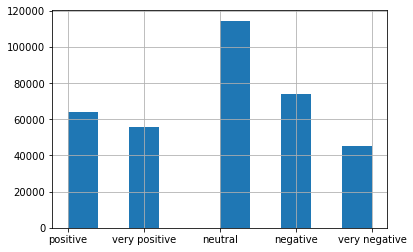

In [44]:
dataset_content[dataset_content.date < "2022-04-01"].output.hist()